<h3>Ensemble Methods

<h4>Importing the Data from OpenML

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

In [ ]:
# Adult (Census Income) – ID: 1590 dataset
set_1590 = fetch_openml(
    name="adult",
    version=2,          # ensures the standard version
    as_frame=True       # returns pandas DataFrame
)
# If an SSL certificate error occurs, run (bash): /Applications/Python\ 3.12/Install\ Certificates.command

# Features and target
X = set_1590.data
y = set_1590.target #Target = 'income'
# Combine into a single DataFrame 
raw_data = X.copy()
raw_data["income"] = y
raw_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# One interesting column of note here: fnlwgt:

### Census sampling weight ##
#
# - Represents how many people in the population this row corresponds to.
# - Will drop as this doesn't necessaruily give any particular information...

raw_data = raw_data.drop('fnlwgt',axis=1)

Here we are going to attempt to model income (target) based on various census variables (predictors)

<h4>Data Cleaning and EDA

<h5>Cleaning:

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   education       48842 non-null  category
 3   education-num   48842 non-null  int64   
 4   marital-status  48842 non-null  category
 5   occupation      46033 non-null  category
 6   relationship    48842 non-null  category
 7   race            48842 non-null  category
 8   sex             48842 non-null  category
 9   capital-gain    48842 non-null  int64   
 10  capital-loss    48842 non-null  int64   
 11  hours-per-week  48842 non-null  int64   
 12  native-country  47985 non-null  category
 13  income          48842 non-null  category
dtypes: category(9), int64(5)
memory usage: 2.3 MB


In [5]:
# A nice mix of numerical and categorical data...

In [6]:
raw_data.isnull().sum()

age                  0
workclass         2799
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [7]:
# The null rows make up less than 10% of the dataset, but due to the
# variety of classes in some of the categorical columns they may not be
# random null values. Outright deletion could skew the dataset...
# Will transform the null values into a new class: 'Unknown'

data = raw_data.copy() #copy raw_data into new variable for 'cleaning'
null_columns = ['workclass','occupation','native-country']

# Add 'Unknown' category to categorical columns before filling null values
for col in null_columns:
    data[col] = data[col].cat.add_categories(["Unknown"])

data[null_columns] = (
    data[null_columns]
    .replace("?", np.nan)
    .fillna("Unknown")
)

print(data.isnull().sum())

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [8]:
unique_rows = data.drop_duplicates().shape[0]
duplicate_rows = len(data) - unique_rows

print(f"Total rows: {len(data)}")
print(f"Unique rows: {unique_rows}")
print(f"'Duplicate' rows: {duplicate_rows}")

# Fair amount of duplicate rows (10-15%). Will just drop them

data = data.drop_duplicates()

Total rows: 48842
Unique rows: 42468
'Duplicate' rows: 6374


In [9]:
# After
unique_rows = data.drop_duplicates().shape[0]
duplicate_rows = len(data) - unique_rows

print(f"Total rows: {len(data)}")
print(f"Unique rows: {unique_rows}")
print(f"'Duplicate' rows: {duplicate_rows}")

Total rows: 42468
Unique rows: 42468
'Duplicate' rows: 0


<h5>EDA

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

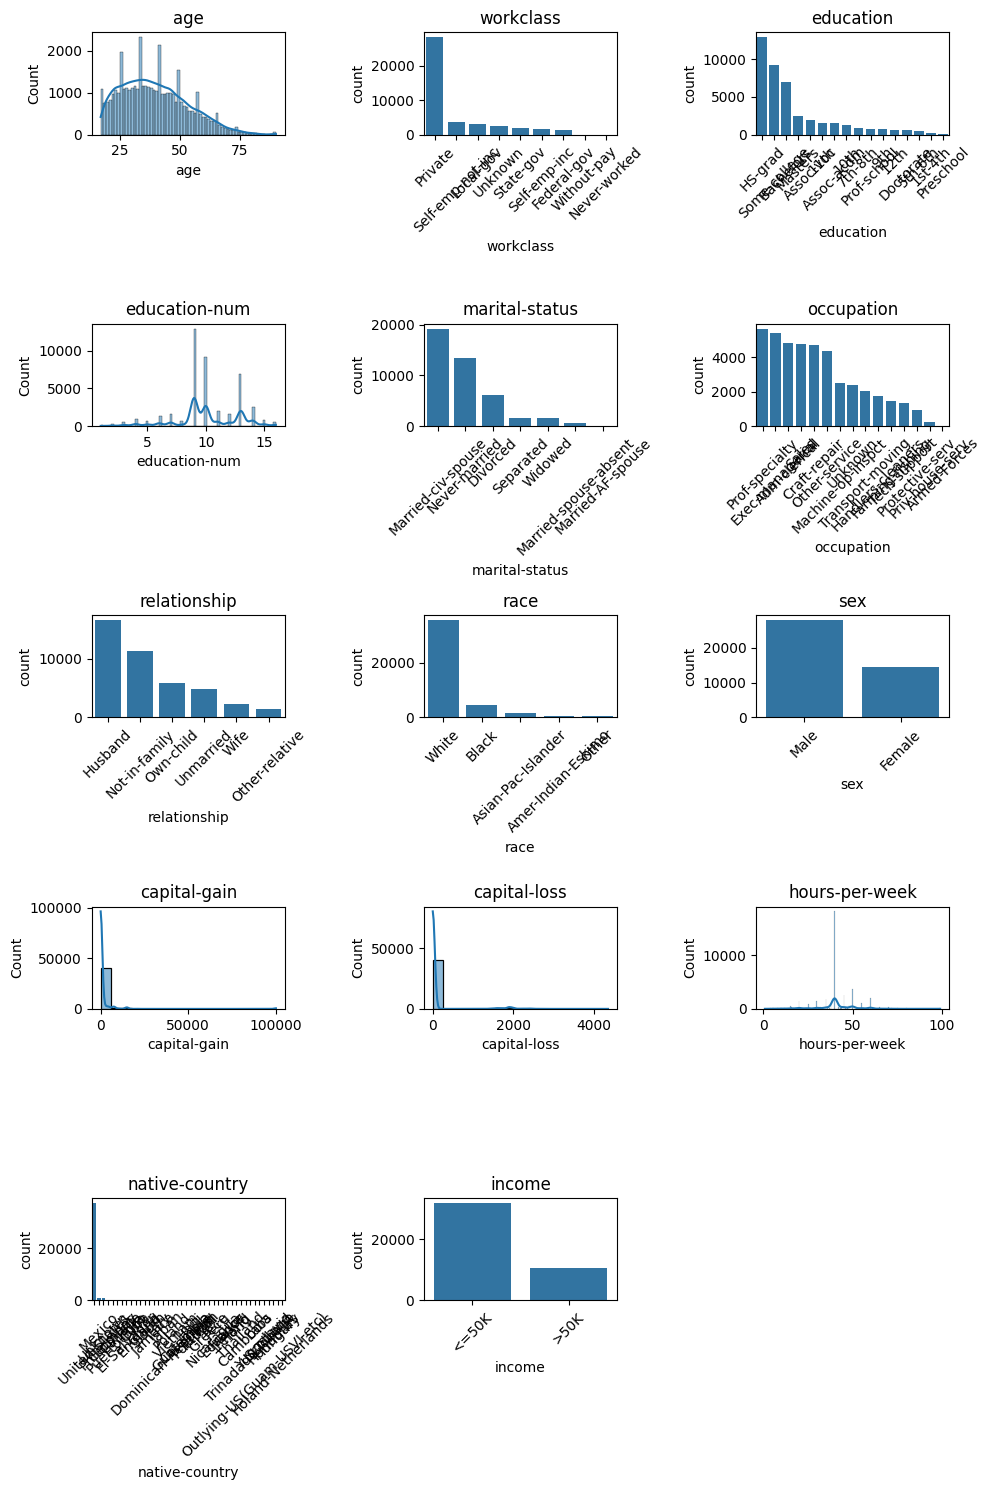

In [11]:
# General distribution:

numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

# Total number of plots
all_cols = list(data.columns)
n_cols = 3  # number of grid columns
n_rows = int(round(len(all_cols) / n_cols))

plt.figure(figsize=(10, n_rows * 3))

for i, col in enumerate(all_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if col in numeric_cols:
        # Numeric -> histogram
        sns.histplot(data[col], kde=True)
    else:
        # Categorical -> count plot
        sns.countplot(x=data[col], order=data[col].value_counts().index)
        plt.xticks(rotation=45)
    
    plt.title(col)

plt.tight_layout()
plt.show()

In [12]:
# Some interesting observations:
# - Male dominated.
# - More low-income vs high-income.
# - Mostly high school grads.
# - Mostly white (race).
# - Mostly married.
# - Dominated by private sector workclass.

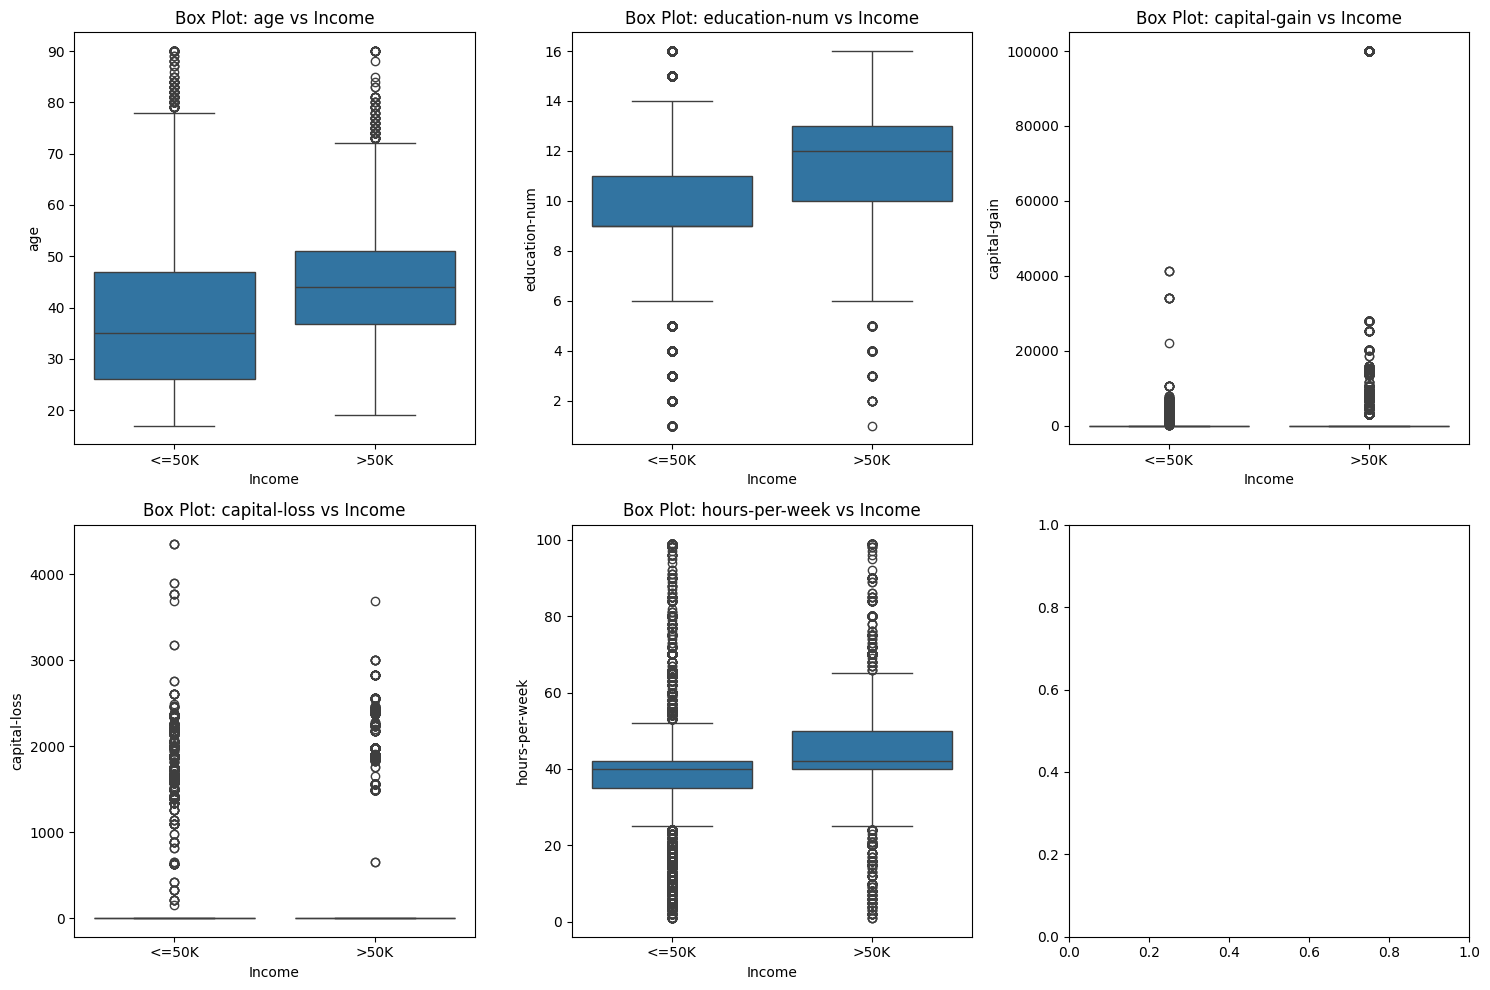

Number of outliers per numeric feature (Z-score > 3):
                       feature  outlier_count  percentage
capital-loss      capital-loss           2178    5.128567
hours-per-week  hours-per-week            605    1.424602
capital-gain      capital-gain            328    0.772346
education-num    education-num            323    0.760573
age                        age            146    0.343788


In [13]:
from scipy import stats

# Boxplots for numerical columns only vs target income (categorical )

# Create box plots for numerical features against target classes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

numeric_columns = data.select_dtypes(include=['number']).columns

for idx, feature in enumerate(numeric_columns):
    sns.boxplot(x='income', y=feature, data=data, ax=axes[idx])
    axes[idx].set_title(f'Box Plot: {feature} vs Income')
    axes[idx].set_xlabel('Income')
    axes[idx].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Calculate Z-scores for outlier detection (only for numeric columns)
numeric_data = data[numeric_columns]
z_scores = np.abs(stats.zscore(numeric_data))
threshold = 3
outliers_mask = (z_scores > threshold)

print(f"Number of outliers per numeric feature (Z-score > {threshold}):")
outlier_counts = pd.DataFrame({
    'feature': numeric_columns,
    'outlier_count': outliers_mask.sum(axis=0),
    'percentage': (outliers_mask.sum(axis=0) / len(numeric_data)) * 100
}).sort_values('outlier_count', ascending=False)

print(outlier_counts)


In [14]:
# ~10% of numeric values are outliers here according to the Z-scores.

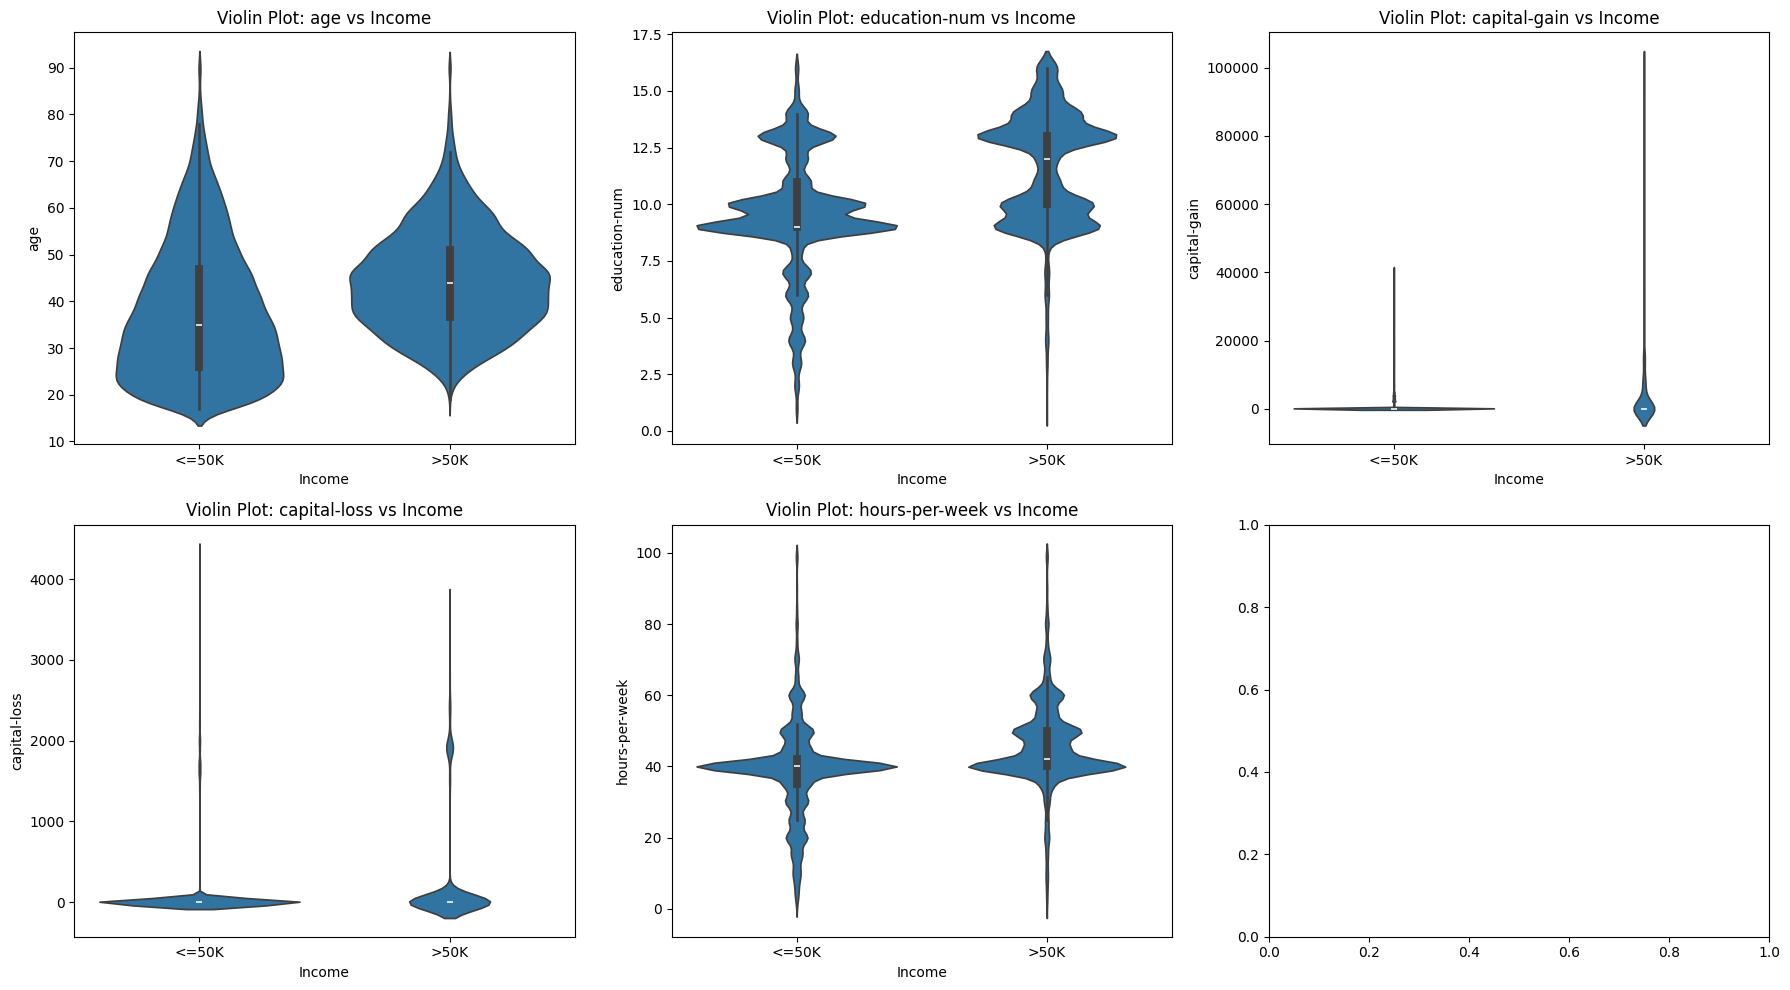

In [15]:
# Violin Plots (distribution)
# Create violin plots for all features against target income
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Plot numeric features
for idx, feature in enumerate(numeric_columns):
    sns.violinplot(x='income', y=feature, data=data, ax=axes[idx])
    axes[idx].set_title(f'Violin Plot: {feature} vs Income')
    axes[idx].set_xlabel('Income')
    axes[idx].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [16]:
# Higher income is associated with longer work hours (slightly), being older and more educated.

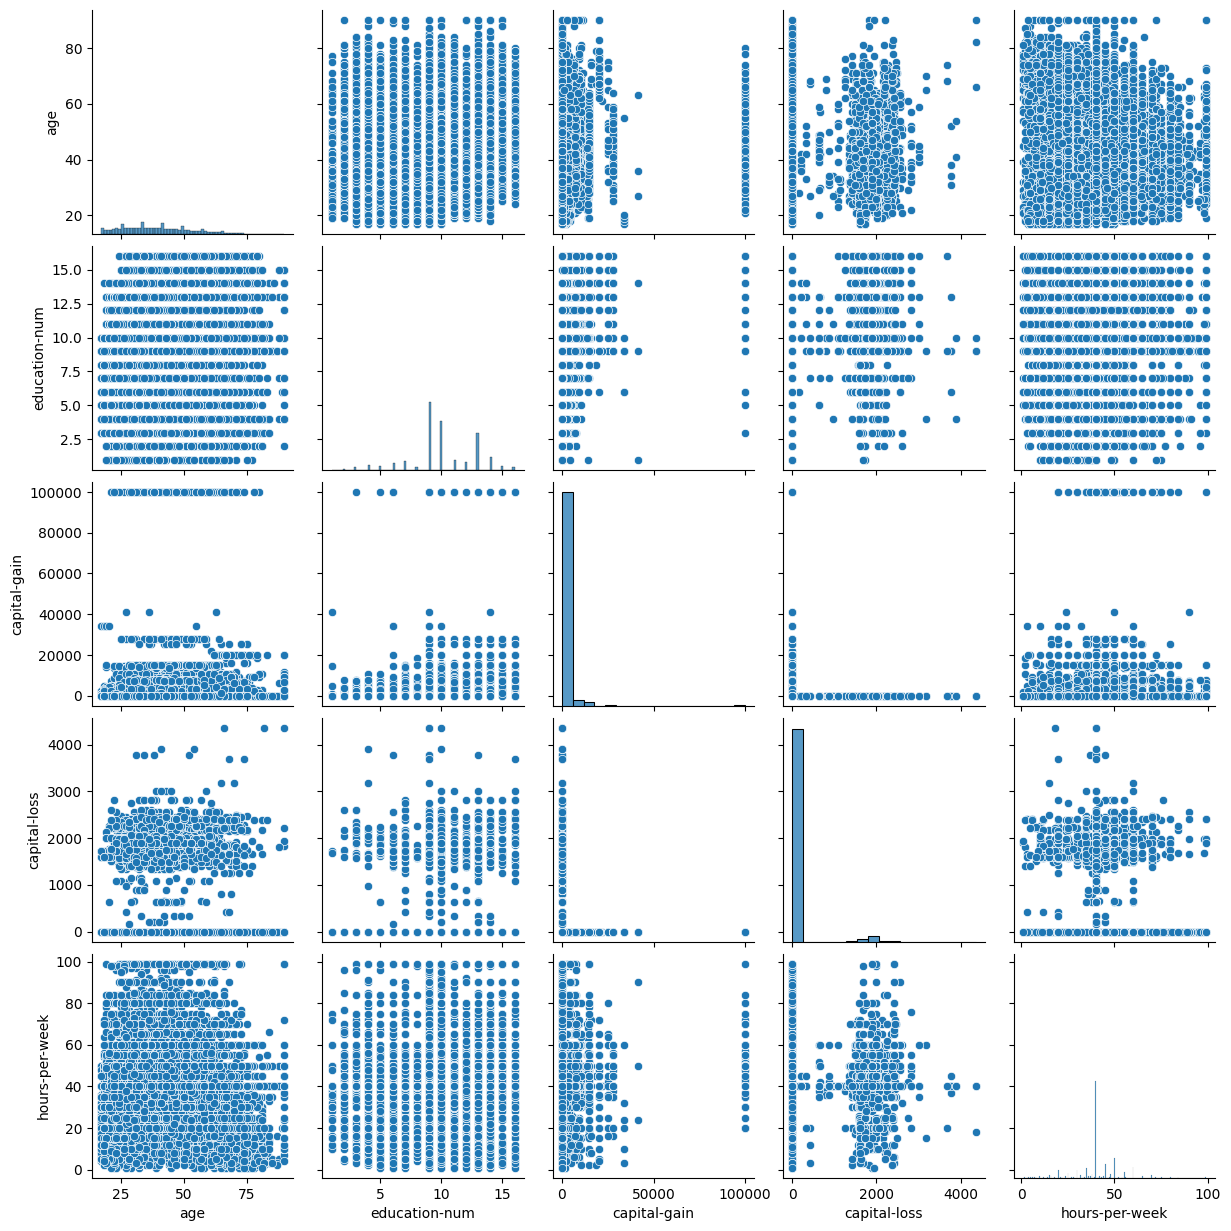

In [17]:
# Pairplots (visual correlation among numerical variables):
sns.pairplot(data[numeric_columns])
plt.show()


In [18]:
# No real visually identifiable correlation here.....

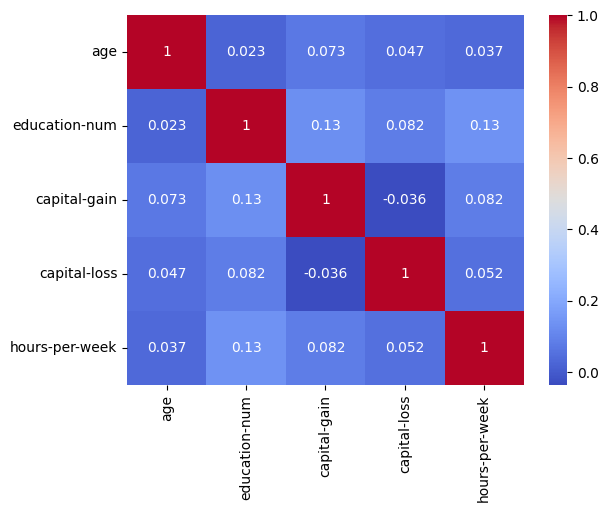

In [19]:
# Pearson correlation (linear relationships between numerical variables):
p_corr = data.corr(numeric_only=True)
sns.heatmap(p_corr, annot=True, cmap='coolwarm')
plt.show()

In [20]:
# Poor linear correlation between the numerical features

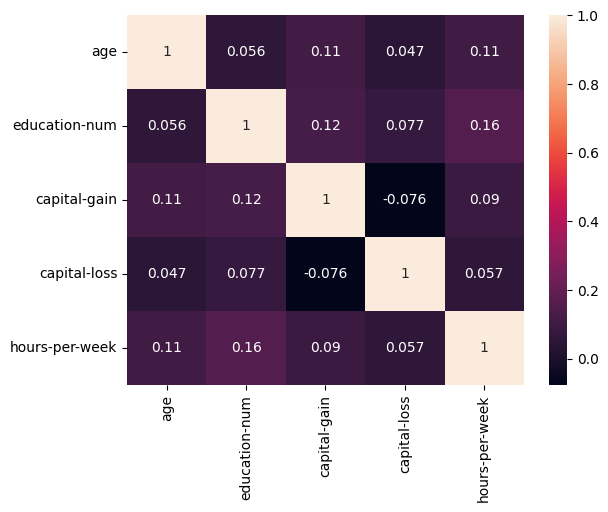

In [21]:
# Spearman correlation (non-linear relationships between numerical variables):
s_corr = data.corr(method='spearman', numeric_only=True)
sns.heatmap(s_corr, annot=True)
plt.show()

In [22]:
# Slightly higher correlation when non-linear relationships are considered. Still quite close to 0...

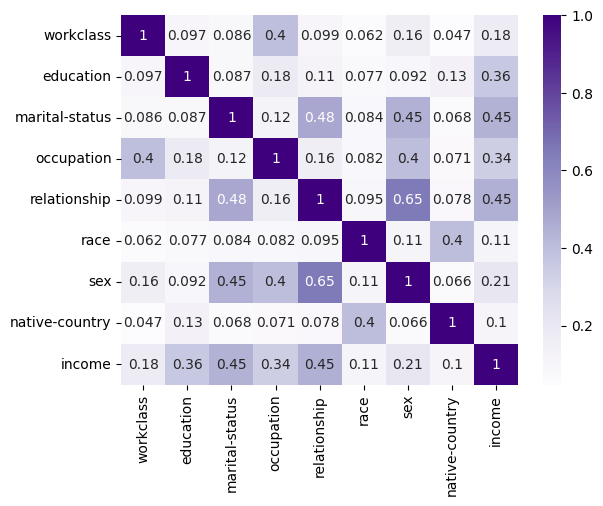

In [23]:
# Cramers V (categorical):

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

# Compute full heatmap - use 'category' dtype instead of 'object'
cat_cols = data.select_dtypes(include='category').columns
cramers_results = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))),
                               index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_results.loc[col1, col2] = cramers_v(data[col1], data[col2])

sns.heatmap(cramers_results, annot=True, cmap="Purples")
plt.show()

In [24]:
# Low correlation among the numerical varaibles but higher correlation among the categorical variables.
# Education, marital status, occupation, and relationship show correlation with income.

In [25]:
# Co-linearity: VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = data.select_dtypes(include=['int64', 'float64']).drop(columns=['income'], errors='ignore')

# Optional: scaling for stability
X_scaled = StandardScaler().fit_transform(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

          feature       VIF
0             age  1.008602
1   education-num  1.039579
2    capital-gain  1.028616
3    capital-loss  1.013210
4  hours-per-week  1.025507


In [26]:
# Low colinearity scores (<5) = each column is contributing unique information to predicting the target.

In [27]:
# 'Missingness' structure: 
# Is the fact that there are missing / 'unknown' values give us information?

def missingness_overview_unknown(
    df,
    target=None,
    unknown_token="Unknown",
    threshold=0.0
):
    """
    Overview of missingness structure when missing values are encoded
    as a sentinel category (e.g. 'Unknown').

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target : str, optional
        Target column name
    unknown_token : str, default="Unknown"
        Value used to represent missingness
    threshold : float, default=0.0
        Minimum fraction of missingness to report

    Returns
    -------
    dict of pd.DataFrame
    """

    results = {}

    # Identify columns containing the unknown token
    cols_with_unknown = [
        col for col in df.columns
        if df[col].astype(str).eq(unknown_token).any()
    ]

    # 1. Missingness fraction
    missing_frac = round((
        df[cols_with_unknown]
        .apply(lambda x: (x == unknown_token).mean())
        .sort_values(ascending=False)
    )*100,1)

    missing_summary = (
        missing_frac[missing_frac > threshold]
        .to_frame("unknown_percentage")
    )

    results["missing_summary"] = missing_summary

    # 2. Missingness vs target
    if target is not None and target in df.columns:
        missing_vs_target = {}

        for col in missing_summary.index:
            indicator = df[col] == unknown_token
            
            # Handle categorical target by encoding or using value_counts
            if df[target].dtype.name == 'category' or df[target].dtype == 'object':
                # For categorical targets, calculate proportion of each category
                target_summary = df.groupby(indicator)[target].apply(
                    lambda x: x.value_counts(normalize=True).to_dict()
                )
                missing_vs_target[col] = target_summary
            else:
                # For numerical targets, use mean
                missing_vs_target[col] = (
                    df.groupby(indicator)[target]
                    .mean()
                    .rename({False: "Observed", True: "Unknown"})
                )

        results["missing_vs_target"] = missing_vs_target

    # 3. Missingness correlation
    if len(missing_summary) > 1:
        missing_indicators = (
            df[missing_summary.index]
            .apply(lambda x: (x == unknown_token).astype(int))
        )

        results["missing_correlation"] = missing_indicators.corr()

    return results

missingness_overview = missingness_overview_unknown(
    data,
    target="income",
    unknown_token="Unknown"
)

In [28]:
missingness_overview['missing_summary'] 
# What percentage of the columns that contain 'unknown' do contain 'unknown'.

,unknown_percentage
occupation,5.7
workclass,5.7
native-country,2.0


In [29]:
missingness_overview['missing_correlation']
# High values (close to 1) means that the values are often missing together.
# Occupation and workclass are often missing together (makes sense).

,occupation,workclass,native-country
occupation,1.000000,0.997808,-0.001902
workclass,0.997808,1.000000,-0.001760
native-country,-0.001902,-0.001760,1.000000


In [30]:
missingness_overview["missing_vs_target"]
# Does having unknown values affect the target?
#
# True = Unknown value
# False = Known value
#
# Higher values for a given class under 'True' indicate that unknown values are likely more associated with
# that class compared to other classes in the target.

{'occupation': occupation       
 False       <=50K    0.745624
             >50K     0.254376
 True        <=50K    0.892193
             >50K     0.107807
 Name: income, dtype: float64,
 'workclass': workclass       
 False      <=50K    0.745687
            >50K     0.254313
 True       <=50K    0.891746
            >50K     0.108254
 Name: income, dtype: float64,
 'native-country': native-country       
 False           <=50K    0.754175
                 >50K     0.245825
 True            <=50K    0.744431
                 >50K     0.255569
 Name: income, dtype: float64}

In [31]:
# Missingness in occupation and workclass is strongly associated with lower income.
# Having the missingness as an explicit predictor of the target is important. It was a good idea to not
# remove these unknowns.

In [32]:
# Class imbalance
data['income'].value_counts(normalize=True)
# Most of the data is associated with a high income (3:1 ratio), highly imbalanced.
# Will need to carry out balancing during training.	

income
<=50K    0.753979
>50K     0.246021
Name: proportion, dtype: float64

In [33]:
# Cardinality analysis:
# How unique is the data in each column?

def cardinality_overview(
    df,
    categorical_cols=None,
    rare_threshold=0.01,
    top_n=3
):
    """
    Provide a brief overview of categorical feature cardinality.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset
    categorical_cols : list, optional
        Categorical columns to analyse. If None, inferred automatically.
    rare_threshold : float, default=0.01
        Frequency threshold below which a category is considered rare
    top_n : int, default=3
        Number of most frequent categories to report

    Returns
    -------
    pd.DataFrame
        Cardinality summary table
    """

    # Infer categorical columns if not provided
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=["object", "category"]).columns

    records = []

    for col in categorical_cols:
        vc = df[col].value_counts(normalize=True)

        records.append({
            "column": col,
            "n_unique": df[col].nunique(),
            "top_category_share": vc.iloc[0],
            "n_rare_categories": (vc < rare_threshold).sum(),
            "top_categories": ", ".join(vc.head(top_n).index.astype(str))
        })

    summary = (
        pd.DataFrame(records)
        .set_index("column")
        .sort_values("n_unique", ascending=False)
    )

    return summary

cardinality_summary = cardinality_overview(data)
cardinality_summary

,n_unique,top_category_share,n_rare_categories,top_categories
column,,,,
native-country,42,0.882829,39,"United-States, Mexico, Unknown"
education,16,0.304206,2,"HS-grad, Some-college, Bachelors"
occupation,15,0.133724,2,"Prof-specialty, Exec-managerial, Adm-clerical"
workclass,9,0.666667,2,"Private, Self-emp-not-inc, Local-gov"
marital-status,7,0.452458,1,"Married-civ-spouse, Never-married, Divorced"
relationship,6,0.391848,0,"Husband, Not-in-family, Own-child"
race,5,0.836889,1,"White, Black, Asian-Pac-Islander"
sex,2,0.659037,0,"Male, Female"
income,2,0.753979,0,"<=50K, >50K"


In [34]:
# A few of the columns are heavily occupied by a single class. 
# e.g. Lots of unique classes in native-country, but 88% of the values are 'United-States'

<h4>Preprocessing

Scaling, encoding, and splitting

In [35]:
# Robust scaling on the numerical columns and encoding of categorical columns. Will apply a pipeline to the data for simplicity.
# For now will use ordinal encoding (keeps same dimensionality) as opposed to the higher performance (for ensemble methods) of
# OneHot encoding (but introduces higher dimensionality and therefore requiring more compute).

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, LabelEncoder

In [36]:
# Create lists to distinguish between categorical and numerical columns (and point out the target)
target_col = "income"
numeric_cols = (data.select_dtypes(include=["number"]).columns.drop(target_col, errors="ignore").tolist())
categorical_cols = (data.select_dtypes(exclude=["number"]).columns.drop(target_col, errors="ignore").tolist())

In [37]:
# Create a single function/object that can be applied to the whole dataset (for X):

preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_cols), # Robust scaling for the numerical data + provide columns
        ("cat", OrdinalEncoder(), categorical_cols), #Ordinal encoding for the categorical data + provide columns
    ],
    remainder="drop"
)

# Best to train-test split the data and then preprocess (scale/encode) the predictors. This helps to reduce data leakage.
# Will need encode the target (y) outside of this pipeline.
# Split -> encode y -> encode/scale x

In [38]:
# Split:
from sklearn.model_selection import train_test_split

X = data.drop('income',axis=1)
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) #use stratify=y for class balancing.

In [39]:
# Encode y:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test) #transform not fit_transform on test (to prevent data leakage)

In [40]:
# Scale/encode X:
X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)

<h4>Modelling

In [ ]:
# Modelling Plan:
#
# 1) Logistic Regression (simple).
# 2) Random Forest Classifier (paralell ensemble).
# 
# Use things like GridSearchCV for hyperparameter tuning of these models.
#
# 3) Gradient Boosting (sequential ensemble).
#
# Cross Validation (measurement/diagnostic technique) for each model.
# Other evaluation techniques such as Bias-Variance, learning curves, 
# confusion matrices, and classification reports.


<h5>Model Evaluation

Cross Validation Metrics:

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss
)

# Preliminary function
def _get_scores_for_proba_or_margin(model, X):
    """
    Returns (proba_positive, margin) where:
    - proba_positive is P(class=1) if available, else None
    - margin is decision_function output if available, else None
    """
    proba_pos = None
    margin = None

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if proba is not None and proba.shape[1] >= 2:
            proba_pos = proba[:, 1]

    if hasattr(model, "decision_function"):
        try:
            margin = model.decision_function(X)
        except Exception:
            margin = None

    return proba_pos, margin

# Main function
def evaluate_classifier(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    cv_splits=5,
    random_state=42,
    pos_label=1,
    model_name=None
):
    """
    Evaluate a binary classification model with CV (and optional test set).

    Parameters
    ----------
    model : estimator or Pipeline
        Any sklearn-compatible classifier (can include preprocessing).
    X_train, y_train : training data
    X_test, y_test : optional held-out test data
    cv_splits : int
        Number of stratified folds for CV.
    random_state : int
        For reproducible shuffling in CV.
    pos_label : int
        Positive class label (typically 1).
    model_name : str, optional
        Name to display in outputs.

    Returns
    -------
    summary_df : pd.DataFrame
        One-row summary with CV mean±std and (if provided) test metrics.
    cv_details : pd.DataFrame
        Fold-by-fold CV scores.
    
    Example
    -------
    >>> results = []
    >>> # Example models (can be Pipelines)
    >>> summary_lr, _ = evaluate_classifier(lr_model, X_train, y_train, X_test, y_test, model_name="LogReg")
    >>> summary_rf, _ = evaluate_classifier(rf_model, X_train, y_train, X_test, y_test, model_name="RandomForest")
    >>> summary_gb, _ = evaluate_classifier(gb_model, X_train, y_train, X_test, y_test, model_name="GradBoost")

    >>> results = pd.concat([summary_lr, summary_rf, summary_gb], ignore_index=True)

    >>> # Sort by your preferred metric
    >>> results.sort_values("cv_roc_auc_mean", ascending=False)
    """
    name = model_name or model.__class__.__name__

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc",
        "neg_log_loss": "neg_log_loss",
    }

    cv_res = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
        error_score="raise",
    )

    # Build per-fold CV details
    cv_details = pd.DataFrame({
        "fold": np.arange(1, cv_splits + 1),
        "accuracy": cv_res["test_accuracy"],
        "precision": cv_res["test_precision"],
        "recall": cv_res["test_recall"],
        "f1": cv_res["test_f1"],
        "roc_auc": cv_res["test_roc_auc"],
        "log_loss": -cv_res["test_neg_log_loss"],
    })

    # Aggregate CV summary
    cv_means = cv_details.drop(columns=["fold"]).mean()
    cv_stds  = cv_details.drop(columns=["fold"]).std(ddof=1)

    summary = {
        "model": name,
        "cv_accuracy_mean": cv_means["accuracy"],
        "cv_accuracy_std": cv_stds["accuracy"],
        "cv_precision_mean": cv_means["precision"],
        "cv_precision_std": cv_stds["precision"],
        "cv_recall_mean": cv_means["recall"],
        "cv_recall_std": cv_stds["recall"],
        "cv_f1_mean": cv_means["f1"],
        "cv_f1_std": cv_stds["f1"],
        "cv_roc_auc_mean": cv_means["roc_auc"],
        "cv_roc_auc_std": cv_stds["roc_auc"],
        "cv_log_loss_mean": cv_means["log_loss"],
        "cv_log_loss_std": cv_stds["log_loss"],
    }

    # Optional test-set evaluation
    if X_test is not None and y_test is not None:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        proba_pos, margin = _get_scores_for_proba_or_margin(model, X_test)

        summary.update({
            "test_accuracy": accuracy_score(y_test, y_pred),
            "test_precision": precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0),
            "test_recall": recall_score(y_test, y_pred, pos_label=pos_label, zero_division=0),
            "test_f1": f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0),
        })

        # ROC-AUC + log loss need a score/probability
        if proba_pos is not None:
            summary["test_roc_auc"] = roc_auc_score(y_test, proba_pos)
            summary["test_log_loss"] = log_loss(y_test, np.column_stack([1 - proba_pos, proba_pos]))
        elif margin is not None:
            summary["test_roc_auc"] = roc_auc_score(y_test, margin)
            summary["test_log_loss"] = np.nan
        else:
            summary["test_roc_auc"] = np.nan
            summary["test_log_loss"] = np.nan

    summary_df = pd.DataFrame([summary])
    
    return summary_df, cv_details

Plot Learning Curve:

In [43]:
from sklearn.model_selection import learning_curve, StratifiedKFold

def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning Curve",
    scoring="roc_auc",
    cv_splits=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42,
    n_jobs=-1
):
    """
    Plot a learning curve (train vs CV score as a function of training set size)
    for a binary classifier. Works with estimators or Pipelines.

    Parameters
    ----------
    estimator : sklearn estimator or Pipeline
        Model to evaluate.
    X, y : array-like / DataFrame
        Full dataset (features + target).
    title : str
        Plot title.
    scoring : str
        sklearn scoring string (e.g., "roc_auc", "accuracy", "f1", "neg_log_loss").
    cv_splits : int
        Number of StratifiedKFold splits.
    train_sizes : array-like
        Fractions or absolute sizes for training set sizes.
    random_state : int
        Seed for shuffling in CV.
    n_jobs : int
        Parallel jobs for learning_curve.

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    data : dict
        Raw learning curve results (sizes, means, stds).

    Example Usage
    --------------
    >>> fig, ax, lc = plot_learning_curve(
    >>>    estimator=model,          # can be a Pipeline
    >>>    X=X_train,                # or full X
    >>>    y=y_train,
    >>>    title="Adult Income — RF Learning Curve",
    >>>    scoring="roc_auc",
    >>>    cv_splits=5
    >>> )
    >>> plt.show()
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=random_state,
        return_times=False
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1, ddof=1)

    val_mean = np.mean(val_scores, axis=1)
    val_std  = np.std(val_scores, axis=1, ddof=1)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.plot(sizes, train_mean, marker="o", label="Training score")
    ax.plot(sizes, val_mean, marker="o", label="Cross-validation score")

    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    ax.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("Training set size")
    ax.set_ylabel(scoring)
    ax.grid(True, alpha=0.3)
    ax.legend()

    data = {
        "train_sizes": sizes,
        "train_mean": train_mean,
        "train_std": train_std,
        "cv_mean": val_mean,
        "cv_std": val_std
    }

    return fig, ax, data


<h5>Logistic Regression

Unoptimised:

In [44]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression:
lr_model = LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        max_iter=1000,
        random_state=42
    )
lr_model.fit(X_train_p, y_train_enc)

# Evaluate: Summary and Details
lr_summary, lr_details = evaluate_classifier(
    model = lr_model,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="LogReg"
    )

In [45]:
lr_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.48216,0.008458,0.763833,0.513578,0.760128,0.61299,0.850258,0.48014


In [46]:
lr_details

,fold,accuracy,precision,recall,f1,roc_auc,log_loss
0,1,0.770098,0.521878,0.782638,0.626196,0.858578,0.470448
1,2,0.765220,0.515780,0.748462,0.610708,0.847150,0.478128
2,3,0.760135,0.508403,0.744870,0.604329,0.843312,0.485983
3,4,0.757275,0.504352,0.753078,0.604115,0.840030,0.492970
4,5,0.763835,0.513501,0.766917,0.615132,0.849250,0.483271


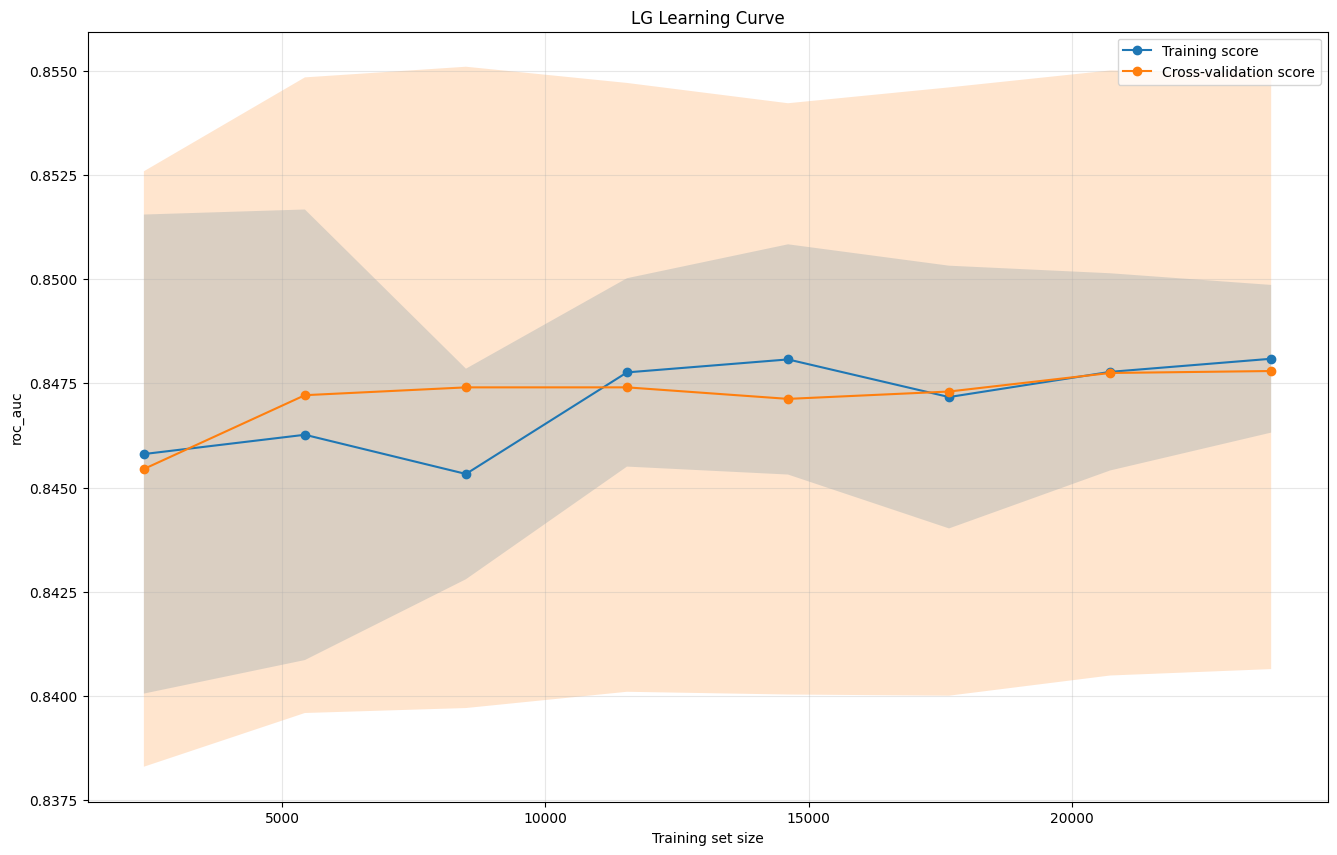

In [47]:
# Evaluate: Learning Curve
fig, ax, lc = plot_learning_curve(
    estimator=lr_model,          
    X=X_train_p,                
    y=y_train_enc,
    title="LG Learning Curve",
    scoring="roc_auc",
    cv_splits=5
)

plt.show()

Optimised:

In [48]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameters to try and the grid_lr

param_grid = [
    # L2 penalty
    {
        "solver": ["lbfgs"], # optimisation algorithm. Different algorithms work for different penalty types.
        "penalty": ["l2"], # penalty types
        "C": np.logspace(-3, 2, 6), # to cover underfitting, balanced and overfitting etc.
        "class_weight": [None, "balanced"] 
    },
    # L1 penalty
    {
        "solver": ["liblinear"],
        "penalty": ["l1"],
        "C": np.logspace(-3, 2, 6),
        "class_weight": [None, "balanced"]
    },
    # Elastic net
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": np.logspace(-3, 2, 6),
        "l1_ratio": [0.2, 0.5, 0.8], #Ratio of L1:L2 penalty applied.
        "class_weight": [None, "balanced"]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [49]:
# Apply:
grid_lr.fit(X_train_p,y_train_enc)
# Very compute intensive. May take a while to run.

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'class_weight': [None, 'balanced'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'class_weight': [None, 'balanced'],
                          'l1_ratio': [0.2, 0.5, 0.8],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [50]:
# Extract the best parameters and test them:
lr_model_best = grid_lr.best_estimator_

lr_best_summary, lr_best_details = evaluate_classifier(
    model = lr_model_best,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="LogRegBest"
    )

In [51]:
lr_best_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogRegBest,0.764524,0.00514,0.514454,0.007048,0.76056,0.016516,0.613734,0.009848,0.848306,0.007259,0.48013,0.008313,0.766737,0.51766,0.762041,0.616516,0.851238,0.477577


In [52]:
lr_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.48216,0.008458,0.763833,0.513578,0.760128,0.61299,0.850258,0.48014


In [53]:
# Concatenate the logistic regression summaries
model_summary = pd.concat([lr_summary, lr_best_summary], ignore_index=True)
model_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.48216,0.008458,0.763833,0.513578,0.760128,0.612990,0.850258,0.480140
1,LogRegBest,0.764524,0.005140,0.514454,0.007048,0.760560,0.016516,0.613734,0.009848,0.848306,0.007259,0.48013,0.008313,0.766737,0.517660,0.762041,0.616516,0.851238,0.477577


<h5>Random Forest Classifier

Unoptimised

In [54]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(
        n_estimators=500, #Number of decision trees in the forest. Have 40k - 50k rows here so will use 500 trees (1 tree per 100 rows) 
        random_state=42,
        n_jobs=-1, #How many CPU cores to use. -1 means use all available cores.
        class_weight="balanced_subsample" #Use a balanced class weight to mitigate target imbalance.
        )

rfc_model.fit(X_train_p, y_train_enc)

# Evaluate: Summary and Details
rfc_summary, rfc_details = evaluate_classifier(
    model = rfc_model,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="RandomForest"
    )


In [55]:
rfc_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,RandomForest,0.837488,0.003757,0.698272,0.010765,0.597839,0.008922,0.644122,0.007849,0.890853,0.006072,0.37715,0.023222,0.83353,0.685036,0.598724,0.638979,0.883807,0.401484


In [56]:
rfc_details

,fold,accuracy,precision,recall,f1,roc_auc,log_loss
0,1,0.842079,0.708931,0.607656,0.654398,0.900777,0.343057
1,2,0.839388,0.708882,0.589200,0.643524,0.890014,0.378346
2,3,0.832128,0.685008,0.587551,0.632548,0.886289,0.402707
3,4,0.835828,0.690439,0.602599,0.643535,0.885658,0.393336
4,5,0.838015,0.698098,0.602187,0.646606,0.891526,0.368303


In [57]:
# Add RF results to model_summary for comparison
model_summary = pd.concat([model_summary, rfc_summary], ignore_index=True)
model_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.48216,0.008458,0.763833,0.513578,0.760128,0.612990,0.850258,0.480140
1,LogRegBest,0.764524,0.005140,0.514454,0.007048,0.760560,0.016516,0.613734,0.009848,0.848306,0.007259,0.48013,0.008313,0.766737,0.517660,0.762041,0.616516,0.851238,0.477577
2,RandomForest,0.837488,0.003757,0.698272,0.010765,0.597839,0.008922,0.644122,0.007849,0.890853,0.006072,0.37715,0.023222,0.833530,0.685036,0.598724,0.638979,0.883807,0.401484


Optimised

In [58]:
# Will use RandomizedSearchCV for RF tuning instead of GridSearchCV to reduce the number of models (and therfore computational resources) required.
# e.g. if in the parameter grid, 5 hyperparameters were explored, each with 3-4 different combinations, 250-1000 models weould be fitted, and with a 5-fold CV
# and 500 trees in total, would lead to millions of fits.

from sklearn.model_selection import RandomizedSearchCV # RSCV

# RSCV uses random combinations of hyperparameters and fits over a defined number of iterations to see if the model can be improved. 
# Add parameter distributions, not a grid:

from scipy.stats import randint

param_dist = {
    # Number of trees
    "n_estimators": randint(300, 900),

    # Tree depth
    "max_depth": [None, 10, 15, 20, 30, 40],

    # Minimum samples to split a node
    "min_samples_split": randint(2, 50),

    # Minimum samples per leaf (leaf = a subset of training samples)
    "min_samples_leaf": randint(1, 20),

    # Number of features considered at each split
    "max_features": ["sqrt", "log2", 0.3, 0.5],

    # Whether to bootstrap samples (make samples random during training or not)
    "bootstrap": [True, False],

    "class_weight": [None, "balanced", "balanced_subsample"],

    # Split criterion
    "criterion": ["gini", "entropy", "log_loss"],
}

In [59]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=rfc_model, #unoptimised model      
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train_p, y_train_enc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_estimators=500, n_jobs=-1,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'...
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B2CBC72390>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B2CBC8E060>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B2CBDADD00>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [60]:
# Extract the best parameters and test them:
rfc_model_best = search.best_estimator_

rfc_best_summary, rfc_best_details = evaluate_classifier(
    model = rfc_model_best,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="RandomForestBest"
    )

In [61]:
rfc_best_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,RandomForestBest,0.835839,0.00621,0.627688,0.01077,0.81813,0.010324,0.710342,0.00982,0.916105,0.005196,0.339206,0.010225,0.832745,0.621609,0.818501,0.706595,0.913863,0.344547


In [62]:
# Add RF results to model_summary for comparison
model_summary = pd.concat([model_summary, rfc_best_summary], ignore_index=True)
model_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.482160,0.008458,0.763833,0.513578,0.760128,0.612990,0.850258,0.480140
1,LogRegBest,0.764524,0.005140,0.514454,0.007048,0.760560,0.016516,0.613734,0.009848,0.848306,0.007259,0.480130,0.008313,0.766737,0.517660,0.762041,0.616516,0.851238,0.477577
2,RandomForest,0.837488,0.003757,0.698272,0.010765,0.597839,0.008922,0.644122,0.007849,0.890853,0.006072,0.377150,0.023222,0.833530,0.685036,0.598724,0.638979,0.883807,0.401484
3,RandomForestBest,0.835839,0.006210,0.627688,0.010770,0.818130,0.010324,0.710342,0.009820,0.916105,0.005196,0.339206,0.010225,0.832745,0.621609,0.818501,0.706595,0.913863,0.344547


<h5>Gradient Boosting

Unoptimised

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
# It isn't possible to add a 'class_weight' parameter directly to the model as before, so
# will need to do some more data prep to balance.

# Compute class weights:

from sklearn.utils.class_weight import compute_sample_weight

sample_training_weight = compute_sample_weight(
    class_weight="balanced",
    y=y_train_enc
)

In [ ]:
# Declare model + train:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_p,y_train_enc, sample_weight=sample_training_weight) # Pass the sample training weights here as a parameter 

GradientBoostingClassifier(random_state=42)

In [66]:
gbc_summary, gbc_details = evaluate_classifier(
    model = gbc,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="GradientBoost"
    )

In [67]:
gbc_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,GradientBoost,0.862818,0.005041,0.791352,0.01298,0.600846,0.016516,0.682971,0.013208,0.919506,0.004991,0.298034,0.008381,0.861863,0.789718,0.597767,0.680465,0.916315,0.30265


In [68]:
model_summary = pd.concat([model_summary, gbc_summary], ignore_index=True)
model_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.482160,0.008458,0.763833,0.513578,0.760128,0.612990,0.850258,0.480140
1,LogRegBest,0.764524,0.005140,0.514454,0.007048,0.760560,0.016516,0.613734,0.009848,0.848306,0.007259,0.480130,0.008313,0.766737,0.517660,0.762041,0.616516,0.851238,0.477577
2,RandomForest,0.837488,0.003757,0.698272,0.010765,0.597839,0.008922,0.644122,0.007849,0.890853,0.006072,0.377150,0.023222,0.833530,0.685036,0.598724,0.638979,0.883807,0.401484
3,RandomForestBest,0.835839,0.006210,0.627688,0.010770,0.818130,0.010324,0.710342,0.009820,0.916105,0.005196,0.339206,0.010225,0.832745,0.621609,0.818501,0.706595,0.913863,0.344547
4,GradientBoost,0.862818,0.005041,0.791352,0.012980,0.600846,0.016516,0.682971,0.013208,0.919506,0.004991,0.298034,0.008381,0.861863,0.789718,0.597767,0.680465,0.916315,0.302650


Optimised

In [71]:
param_grid = {
    "n_estimators": [100, 200, 400, 800],
    "learning_rate": [0.025,0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6,0.8, 1.0],
}

gbc_grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
) #Apply the sample weight to the gbc_grid.fit step


In [ ]:
gbc_grid.fit(X_train_p,y_train_enc,sample_weight=sample_training_weight)
# Takes ~5 mins to run (pretty compute intensive!)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.025, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 400, 800],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [74]:
gbc_model_best = gbc_grid.best_estimator_

gbc_best_summary, gbc_best_details = evaluate_classifier(
    model = gbc_model_best,
    X_train=X_train_p,
    y_train=y_train_enc,
    X_test=X_test_p,
    y_test=y_test_enc,
    model_name="GradientBoostBest"
    )

In [75]:
gbc_best_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,GradientBoostBest,0.869781,0.004233,0.774019,0.006682,0.664704,0.017132,0.715137,0.011583,0.927005,0.004446,0.281841,0.009169,0.871831,0.777737,0.670813,0.720329,0.926787,0.282433


In [76]:
model_summary = pd.concat([model_summary, gbc_best_summary], ignore_index=True)
model_summary

,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_f1_mean,cv_f1_std,cv_roc_auc_mean,cv_roc_auc_std,cv_log_loss_mean,cv_log_loss_std,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_log_loss
0,LogReg,0.763313,0.004912,0.512783,0.006754,0.759193,0.015549,0.612096,0.009138,0.847664,0.007055,0.482160,0.008458,0.763833,0.513578,0.760128,0.612990,0.850258,0.480140
1,LogRegBest,0.764524,0.005140,0.514454,0.007048,0.760560,0.016516,0.613734,0.009848,0.848306,0.007259,0.480130,0.008313,0.766737,0.517660,0.762041,0.616516,0.851238,0.477577
2,RandomForest,0.837488,0.003757,0.698272,0.010765,0.597839,0.008922,0.644122,0.007849,0.890853,0.006072,0.377150,0.023222,0.833530,0.685036,0.598724,0.638979,0.883807,0.401484
3,RandomForestBest,0.835839,0.006210,0.627688,0.010770,0.818130,0.010324,0.710342,0.009820,0.916105,0.005196,0.339206,0.010225,0.832745,0.621609,0.818501,0.706595,0.913863,0.344547
4,GradientBoost,0.862818,0.005041,0.791352,0.012980,0.600846,0.016516,0.682971,0.013208,0.919506,0.004991,0.298034,0.008381,0.861863,0.789718,0.597767,0.680465,0.916315,0.302650
5,GradientBoostBest,0.869781,0.004233,0.774019,0.006682,0.664704,0.017132,0.715137,0.011583,0.927005,0.004446,0.281841,0.009169,0.871831,0.777737,0.670813,0.720329,0.926787,0.282433


<h4> Final Evaluations + Comparisons

In [84]:
clean_model_summary = model_summary[['cv_accuracy_mean', 'cv_precision_mean','cv_recall_mean','cv_f1_mean','cv_roc_auc_mean','cv_log_loss_mean','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc','test_log_loss']]
clean_model_summary.columns = [
    'CV Accuracy', 'CV Precision', 'CV Recall', 'CV F1', 'CV ROC-AUC', 'CV Log Loss',
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC-AUC', 'Test Log Loss'
]
clean_model_summary.index = ['Logistic Regression', 'Logistic Regression Optimised', 'Random Forest Classifier', 'Random Forest Classifier Optimised', 'Gradient Boost Classifier', 'Gradient Boost Classifier Optimised']
clean_model_summary = clean_model_summary.round(3)
clean_model_summary

,CV Accuracy,CV Precision,CV Recall,CV F1,CV ROC-AUC,CV Log Loss,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC,Test Log Loss
Logistic Regression,0.763,0.513,0.759,0.612,0.848,0.482,0.764,0.514,0.760,0.613,0.850,0.480
Logistic Regression Optimised,0.765,0.514,0.761,0.614,0.848,0.480,0.767,0.518,0.762,0.617,0.851,0.478
Random Forest Classifier,0.837,0.698,0.598,0.644,0.891,0.377,0.834,0.685,0.599,0.639,0.884,0.401
Random Forest Classifier Optimised,0.836,0.628,0.818,0.710,0.916,0.339,0.833,0.622,0.819,0.707,0.914,0.345
Gradient Boost Classifier,0.863,0.791,0.601,0.683,0.920,0.298,0.862,0.790,0.598,0.680,0.916,0.303
Gradient Boost Classifier Optimised,0.870,0.774,0.665,0.715,0.927,0.282,0.872,0.778,0.671,0.720,0.927,0.282


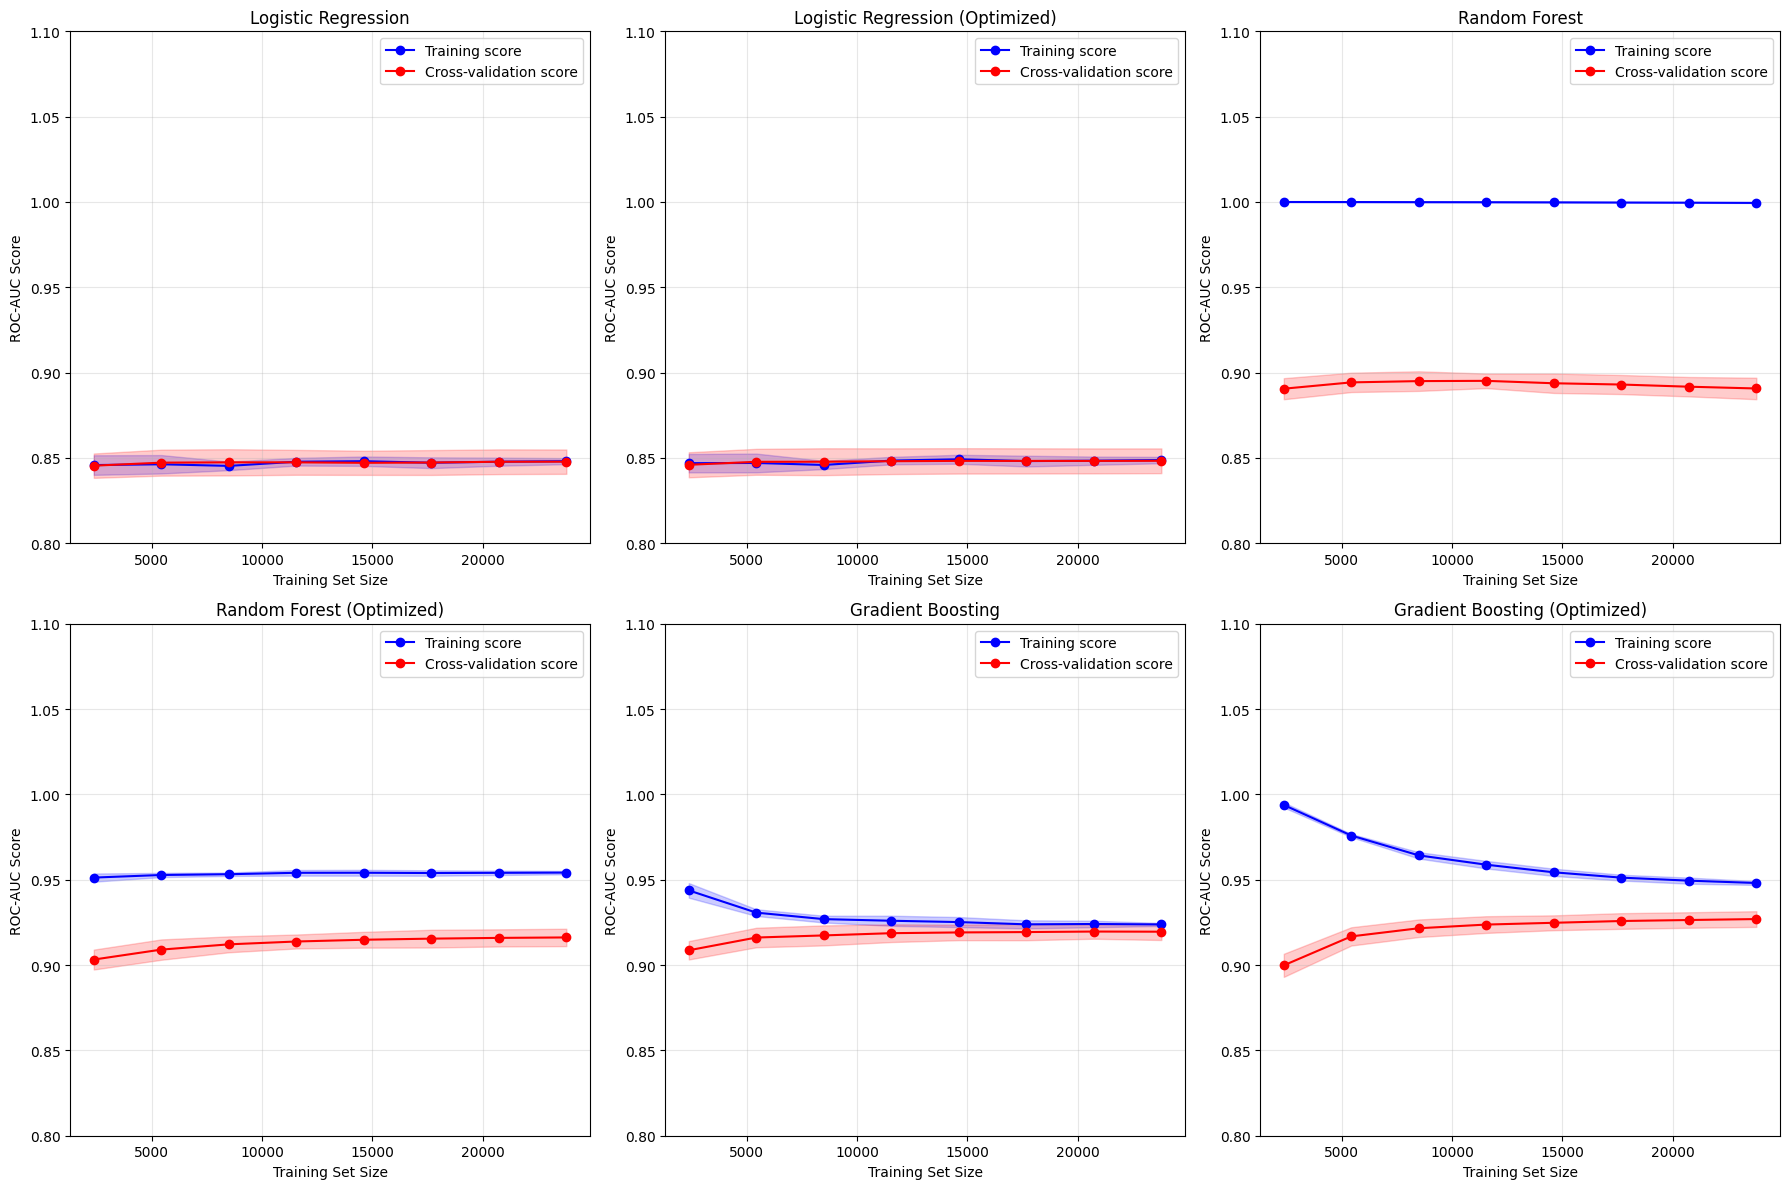

In [ ]:

models_to_plot = [
    (lr_model, "Logistic Regression"),
    (lr_model_best, "Logistic Regression (Optimized)"),
    (rfc_model, "Random Forest"),
    (rfc_model_best, "Random Forest (Optimized)"),
    (gbc, "Gradient Boosting"),
    (gbc_model_best, "Gradient Boosting (Optimized)")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model, title) in enumerate(models_to_plot):
    # Get learning curve data
    sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train_p,
        y=y_train_enc,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="roc_auc",
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1, ddof=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1, ddof=1)
    
    
    ax = axes[idx]
    ax.plot(sizes, train_mean, marker="o", label="Training score", color='blue')
    ax.plot(sizes, val_mean, marker="o", label="Cross-validation score", color='red')
    
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    ax.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("ROC-AUC Score")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(0.8, 1.1)  

plt.tight_layout()
plt.show()